In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.integrate import solve_ivp

from coropy.compartmental_models import SEIRDModel
import plotting

plotting.configure()
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')

In [26]:
# all data
DATA_DIR = 'data'
FILE_NAME = 'initial_timeseries_SEIRD.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

$$
\begin{aligned}
\frac{S(t)}{\Delta t} &= -\frac{\beta \cdot S(t) \cdot I(t)}{N} - \langle \delta \rangle \cdot S(t) \cdot E(t) \\
\frac{E(t)}{\Delta t} &= \frac{\beta \cdot S(t) \cdot I(t)}{N} - \langle \alpha \rangle \cdot E(t) + \langle \delta \rangle \cdot S(t) \cdot E(t) \\
\frac{I(t)}{\Delta t} &= \langle \alpha \rangle \cdot E(t) - \langle \gamma \rangle \cdot I(t) - \mu \cdot I(t) \\
\frac{R(t)}{\Delta t} &= \langle \gamma \rangle \cdot I(t) \\
\frac{D(t)}{\Delta t} &= \langle \mu \rangle \cdot I(t) \\ \\
\beta &= 0.5 \\
N &= S(t) + E(t) + I(t) + R(t) + D(t)
\end{aligned}
$$

In [239]:
# initial conditions
S0 = cum_positives[-1] + cum_deceased[-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
IC = [S0, E0, I0, R0, D0]

# dates
t = np.arange(cum_positives.size)
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(int(t.max())+1)
dates = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))

# transmission rate
beta = 0.5

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model = SEIRDModel(ode_system=SEIRD_ode)
params, loss = model.fit(cum_positives, cum_recovered, cum_deceased, IC, guess=[0.1, 0.1, 0.1, 0.1])
S, E, I, R, D = model.simulate()

INFO:root:L-BFGS-B optimization started: 2020-10-11 16:59:16.128930
INFO:root:Elapsed time: 23.7677s


In [275]:
# metropolis-hastings

n_iters = 1000
I_star = np.zeros(shape=(n_iters, t.size))
R_star = np.zeros(shape=(n_iters, t.size))
D_star = np.zeros(shape=(n_iters, t.size))
for i in range(n_iters):
    noisy_S0 = np.random.normal(loc=S0, scale=0.2*S0)
    noisy_E0 = np.random.normal(loc=E0, scale=0.2*E0)
    noisy_params = np.random.normal(loc=params, scale=0.2*params, size=params.size)
    noisy_sol = solve_ivp(
        SEIRD_ode,
        t_span=(0, int(t[-1])),
        y0=[noisy_S0, noisy_E0, I0, R0, D0],
        args=noisy_params,
        method='RK45',
        t_eval=t,
        vectorized=True,
    )
    I_star[i, :] = noisy_sol.y[2]
    R_star[i, :] = noisy_sol.y[3]
    D_star[i, :] = noisy_sol.y[4]

In [276]:
I_star_exp = np.mean(I_star, axis=0)
I_star_err = np.std(I_star, axis=0)

R_star_exp = np.mean(R_star, axis=0)
R_star_err = np.std(R_star, axis=0)

D_star_exp = np.mean(D_star, axis=0)
D_star_err = np.std(D_star, axis=0)

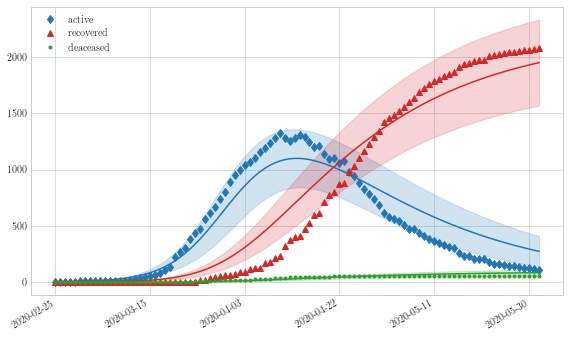

In [277]:
# active
fig = plt.figure()
plt.plot(dates, active, 'd', c=b, label='active')
plt.plot(dates, I_star_exp, '-', c=b)
plt.fill_between(dates, I_star_exp - I_star_err, I_star_exp + I_star_err, color=b, alpha=0.2)
    
# recovered
plt.plot(dates, cum_recovered, '^', c=r, label='recovered')
plt.plot(dates, R_star_exp, '-', c=r)
plt.fill_between(dates, R_star_exp - R_star_err, R_star_exp + R_star_err, color=r, alpha=0.2)

# deceased
plt.plot(dates, cum_deceased, '.', c=g, label='deaceased')
plt.plot(dates, D_star_exp, '-', c=g)
plt.fill_between(dates, D_star_exp - D_star_err, D_star_exp + D_star_err, color=g, alpha=0.2)

plt.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()